# Evaluation of portfolio

This notebook contains code to generate metrics for portfolio evaluation. These include
* classification matrix, ROC curve and AUC score for prediction (section 2)
* daily and cumulative returns of portfolio (section 3.1)
* annual vola and sharpe ratio (section 3.2)

The notebook can be run on its own, requiring only two input files
* input stock price data ```data_rfc_sgx_2022M10.csv``` containing stock price data from 2022M1-M10
* saved RF model, ```rf_random_221031.pkl``` which was trained using data from 2022M1-M7

## 1. Data preparation

### 1.1 Importing libraries, loading data, and choice of stocks

In [1]:
## Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

# load data
data = pd.read_csv("data_rfc_sgx_2022M10.csv", header = [0,1,2])

def get_prices(symbol,data):
    print(symbol)
    headers = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    prices = [data.loc[:,(header,symbol)].copy().reset_index(drop=True) for header in headers]
    dates = data.loc[:,("Unnamed: 0_level_0","Unnamed: 0_level_1","Date")].reset_index(drop = True)
    combined_lst = [dates] + prices
    combined_df = pd.concat(combined_lst, axis = 1)
    combined_df.columns = ["date"] + [header.lower() for header in headers]
    combined_df = combined_df.interpolate()
#     assert(not combined_df.isnull().values.any())
    combined_df.loc[:,"symbol"] = symbol
    return combined_df

def get_multiple(symbols, data):
    multiple_stock_lst = [get_prices(symbol, data) for symbol in symbols]
    multiple_stock_df = pd.concat(multiple_stock_lst).reset_index(drop = True)
    return multiple_stock_df

# choice of 10 SGX-listed stocks
symbols = ["D05.SI","S58.SI","BS6.SI","U11.SI","Z74.SI","O39.SI","U96.SI","C07.SI","S51.SI","C09.SI"]
price_data = get_multiple(symbols, data)

D05.SI
S58.SI
BS6.SI
U11.SI
Z74.SI
O39.SI
U96.SI
C07.SI
S51.SI
C09.SI


### 1.2 Preprocess data
This follows the same set up that was used to train the RFC model

In [2]:
# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','date'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['adj close'].diff()

# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 10, corresponding to 10 stocks in our portfolio
price_data[price_data.isna().any(axis = 1)]

,date,adj close,close,high,low,open,volume,symbol,change_in_price
424,2022-01-03 00:00:00,1.275824,1.350000,1.350000,1.340000,1.340000,2757300.0,BS6.SI,NaN
1484,2022-01-03 00:00:00,20.530001,20.530001,20.639999,20.440001,20.620001,72500.0,C07.SI,NaN
1908,2022-01-03 00:00:00,6.775853,6.880000,6.890000,6.830000,6.830000,796900.0,C09.SI,NaN
0,2022-01-03 00:00:00,31.749357,32.790001,32.830002,32.720001,32.799999,1610600.0,D05.SI,NaN
1060,2022-01-03 00:00:00,10.891167,11.400000,11.440000,11.370000,11.440000,2115000.0,O39.SI,NaN
1696,2022-01-03 00:00:00,0.082000,0.082000,0.083000,0.081000,0.082000,24574500.0,S51.SI,NaN
212,2022-01-03 00:00:00,3.890000,3.890000,3.920000,3.890000,3.890000,551600.0,S58.SI,NaN
636,2022-01-03 00:00:00,25.831663,26.930000,27.030001,26.889999,27.000000,1047200.0,U11.SI,NaN
1272,2022-01-03 00:00:00,2.010000,2.010000,2.020000,2.000000,2.000000,1190600.0,U96.SI,NaN
848,2022-01-03 00:00:00,2.287475,2.330000,2.340000,2.320000,2.330000,11174600.0,Z74.SI,NaN


### 1.3 Generating input features (ie trading indicators)

In [3]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), 
# meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].\
                                     transform(lambda x: x.pct_change(periods = n))

# calculating OBV

def obv(group):

    # Grab the volume and close column.
    volume = group['volume']
    change = group['close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    # NOte: need to make sure this a pandas.series
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
# price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)
price_data['On Balance Volume'] = obv_groups.to_numpy().reshape(-1,1)

# # display the data frame.
# price_data.head()

### 1.4 Creating the Prediction Column, and separate data to train, val, and test periods
These three sets of data are needed to load the saved RF model ```rf_random_221031.pkl```

In [4]:
# Create a column we wish to predict

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. 
# To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], 
                                                              price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], 
                                                             price_data.shape[1]))


# Separate the dataset into pre 2022-08-01 and between(2022-08-01, 2022-09-30)
price_data.loc[:,"datetime"] = pd.to_datetime(price_data.date)
price_data_copy = price_data.copy()

# 29th July 2022 is a Friday
price_data_eval = price_data_copy.loc[
    price_data.datetime.between( 
        pd.to_datetime("2022-07-29"), 
        pd.to_datetime("2022-09-30")
        )
    ].reset_index(drop = True)

price_data_oct = price_data_copy.loc[
    price_data.datetime.between( 
        pd.to_datetime("2022-09-30"), 
        pd.to_datetime("2022-10-31")
        )
    ].reset_index(drop = True)

price_data = price_data.loc[
    price_data.datetime < pd.to_datetime("2022-08-01")
                                ].reset_index(drop = True)

Before NaN Drop we have 2120 rows and 21 columns
After NaN Drop we have 1997 rows and 21 columns


## 2. Making prediction using model saved

### 2.1 Validation period, 2022M8-M9

Correct Prediction: 76.28%


,precision,recall,f1-score,support
Down Day,0.73,0.79,0.76,204.00
Up Day,0.80,0.73,0.76,226.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.76,0.76,0.76,430.00
weighted avg,0.77,0.76,0.76,430.00


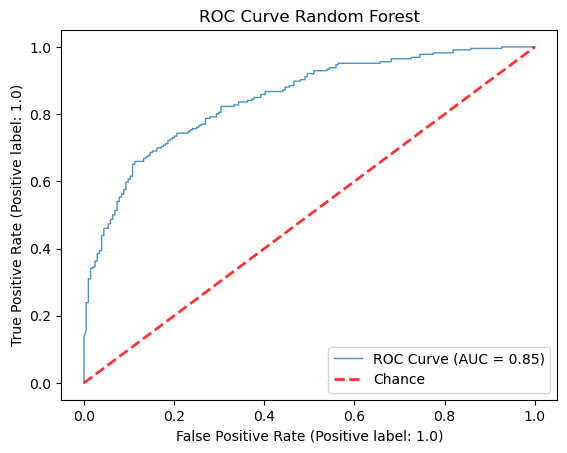

In [5]:
# Load saved model
import joblib
rf_random = joblib.load("rf_random_221031.pkl") 
clf = rf_random

# Grab our X & Y Columns.
X_Cols_eval = price_data_eval[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols_eval = price_data_eval['Prediction']

# Make predictions
y_pred_eval = rf_random.predict(X_Cols_eval)
y_pred_eval_proba = rf_random.predict_proba(X_Cols_eval)
y_pred_eval_proba.max(axis = 1)

price_data_eval.loc[:,"model_prediction"] = y_pred_eval
price_data_eval.loc[:,"model_proba"] = y_pred_eval_proba.max(axis = 1)

# evaluate model
from sklearn import metrics

y_pred = y_pred_eval
X_test = X_Cols_eval
y_test = Y_Cols_eval

acc_score = metrics.accuracy_score(y_test, y_pred, 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(clf, 
                          X_test, y_test, 
                          alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

In [6]:
cumreturns_eval_dct = {}
symbol_eval_dct = {}
returns_eval_dct = {}

for symbol in symbols:
    symbol_eval = price_data_eval.loc[price_data_eval.symbol == symbol,:].copy().reset_index(drop = True)
    symbol_eval.loc[:,"action"] = symbol_eval.model_prediction
    
    # If model predicts with a probability of 0.6, do 
    symbol_eval.loc[symbol_eval.model_proba < 0.6, "action"] = 0
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Buy
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Sell
    # If model predicts with probaility < 0.6 -> Do nothing
    
    current = symbol_eval["adj close"][1:].reset_index(drop = True)
    previous = symbol_eval["adj close"][:-1].reset_index(drop = True)
    change = (current - previous)/previous
    
    symbol_eval.loc[:,"change"] = change
    action = symbol_eval["action"][:-1].reset_index(drop = True)
    returns = action * change
        
    symbol_eval = symbol_eval[1:].reset_index(drop=True)
    symbol_eval.loc[:,"returns"] = returns
    

    cumreturns_eval = (1+returns).cumprod()
    symbol_eval.loc[:,"cumreturns"] = cumreturns_eval
    
    symbol_eval_dct[symbol] = symbol_eval.copy()
    
    returns_eval = float(cumreturns_eval.tail(1))
    returns_eval_dct[symbol] = returns_eval
    
#     print(f"{symbol} returns: {float((1+returns).cumprod().tail(1))}")

return_eval_summary = pd.DataFrame(columns = [])
return_eval_summary.index = symbol_eval_dct[symbols[0]].date

cumreturn_eval_summary = pd.DataFrame(columns = [])
cumreturn_eval_summary.index = symbol_eval_dct[symbols[0]].date

for symbol in symbols:
    symbol_eval = symbol_eval_dct[symbol]
    return_eval_summary.loc[symbol_eval.date.tolist(),symbol] = symbol_eval.returns.to_numpy().reshape(-1,1)
    cumreturn_eval_summary.loc[symbol_eval.date.tolist(),symbol] = symbol_eval.cumreturns.to_numpy().reshape(-1,1)

#### 2.1.2 Calculated returns (>10%) for validation period, 2022M8-M9

In [7]:
# daily returns
return_eval_summary = return_eval_summary.fillna(0)
return_eval_summary.loc[:,"mean"] = return_eval_summary.mean(axis = 1)

# cumulative returns
cumreturn_eval_summary = cumreturn_eval_summary.fillna(method = 'ffill')
cumreturn_eval_summary.loc[:,"mean"] = cumreturn_eval_summary.mean(axis = 1)

# show cumulative returns
cumreturn_eval_summary

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-08-01 00:00:00,0.991738,1.002519,1.000000,0.987659,0.988506,1.000000,0.979381,1.050357,1.009174,1.000000,1.000933
2022-08-02 00:00:00,0.991113,0.997481,1.000000,0.993325,0.988506,1.006814,0.979381,1.067857,1.027523,0.993598,1.004560
2022-08-03 00:00:00,1.010492,1.010076,1.010870,0.991534,0.996928,1.021295,0.979381,1.086786,1.045872,0.993598,1.014683
2022-08-04 00:00:00,1.012992,1.012594,0.999761,0.989392,0.993034,1.040034,0.979381,1.103571,1.064220,1.020280,1.021526
2022-08-05 00:00:00,1.026432,1.022670,0.999761,0.989392,1.016218,1.042589,0.979381,1.100000,1.055046,1.029174,1.026066
2022-08-08 00:00:00,1.024244,1.020151,0.999761,0.989756,1.012354,1.045997,0.979381,1.104643,1.082569,1.041880,1.030074
2022-08-09 00:00:00,1.031589,1.022670,0.999761,0.989756,1.018150,1.049830,0.985541,1.112500,1.087156,1.045057,1.034201
2022-08-10 00:00:00,1.038934,1.025189,1.007717,0.989756,1.023946,1.053663,0.991701,1.120357,1.091743,1.048233,1.039124
2022-08-11 00:00:00,1.046123,1.030227,1.034236,0.980277,1.012354,1.061329,1.000940,1.122143,1.091743,1.046963,1.042633


### 2.2 Test period, 2022M10

#### 2.2.1 Using prediction to inform buy/sell

Correct Prediction: 67.34%


,precision,recall,f1-score,support
Down Day,0.61,0.89,0.72,96.00
Up Day,0.82,0.48,0.60,103.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.71,0.68,0.66,199.00
weighted avg,0.72,0.67,0.66,199.00


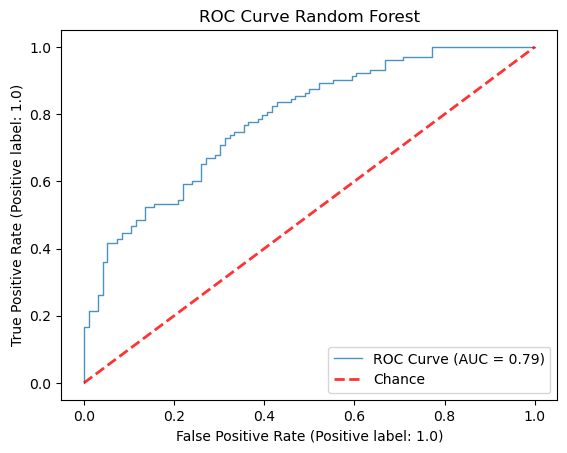

In [8]:
# Load saved model
rf_random = joblib.load("rf_random_221031.pkl") 
clf = rf_random

# Grab our X & Y Columns.
X_Cols_oct = price_data_oct[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols_oct = price_data_oct['Prediction']

# Make predictions
y_pred_oct = rf_random.predict(X_Cols_oct)
y_pred_oct_proba = rf_random.predict_proba(X_Cols_oct)
price_data_oct.loc[:,"model_prediction"] = y_pred_oct

price_data_oct.loc[:,"model_proba"] = y_pred_oct_proba.max(axis = 1)
price_data_oct

# evaluate model
from sklearn import metrics

y_pred = y_pred_oct
X_test = X_Cols_oct
y_test = Y_Cols_oct

acc_score = metrics.accuracy_score(y_test, y_pred, 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(clf, 
                          X_test, y_test, 
                          alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

#### 2.2.2 Calculated returns (>4%) for test period, 2022M10

In [9]:
cumreturns_oct_dct = {}
symbol_oct_dct = {}
returns_oct_dct = {}

for symbol in symbols:
    symbol_oct = price_data_oct.loc[price_data_oct.symbol == symbol,:].copy().reset_index(drop = True)
    symbol_oct.loc[:,"action"] = symbol_oct.model_prediction
    
    # If model predicts with a probability of 0.6, do 
    symbol_oct.loc[symbol_oct.model_proba < 0.6, "action"] = 0
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Buy
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Sell
    # If model predicts with probaility < 0.6 -> Do nothing
    
    current = symbol_oct["adj close"][1:].reset_index(drop = True)
    previous = symbol_oct["adj close"][:-1].reset_index(drop = True)
    change = (current - previous)/previous
    
    symbol_oct.loc[:,"change"] = change
    action = symbol_oct["action"][:-1].reset_index(drop = True)
    returns = action * change
        
    symbol_oct = symbol_oct[1:].reset_index(drop=True)
    symbol_oct.loc[:,"returns"] = returns
    

    cumreturns_oct = (1+returns).cumprod()
    symbol_oct.loc[:,"cumreturns"] = cumreturns_oct
    
    symbol_oct_dct[symbol] = symbol_oct.copy()
    
    returns_oct = float(cumreturns_oct.tail(1))
    returns_oct_dct[symbol] = returns_oct

# create df for 2022M10 returns    
return_oct_summary = pd.DataFrame(columns = [])
return_oct_summary.index = symbol_oct_dct[symbols[0]].date
cumreturn_oct_summary = pd.DataFrame(columns = [])
cumreturn_oct_summary.index = symbol_oct_dct[symbols[0]].date

for symbol in symbols:
    symbol_oct = symbol_oct_dct[symbol]
    return_oct_summary.loc[symbol_oct.date.tolist(),symbol] = symbol_oct.returns.to_numpy().reshape(-1,1)
    cumreturn_oct_summary.loc[symbol_oct.date.tolist(),symbol] = symbol_oct.cumreturns.to_numpy().reshape(-1,1)

# fill na for missing data
return_oct_summary = return_oct_summary.fillna(0)
return_oct_summary.loc[:,"mean"] = return_oct_summary.mean(axis = 1)
cumreturn_oct_summary = cumreturn_oct_summary.fillna(method = 'ffill')
cumreturn_oct_summary.loc[:,"mean"] = cumreturn_oct_summary.mean(axis = 1)

# display cumulative returns in 2022M10
cumreturn_oct_summary

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-10-03 00:00:00,1.007188,1.006645,1.009709,1.003440,0.977444,1.000000,NaN,0.984315,NaN,1.000000,0.998592
2022-10-04 00:00:00,1.000200,1.006645,0.989911,1.000361,0.973684,0.985544,0.996753,0.956208,1.000000,1.000000,0.990931
2022-10-05 00:00:00,0.999001,1.020111,0.989911,0.986972,0.996068,0.990501,1.009656,0.952145,1.045872,1.000000,0.999024
2022-10-06 00:00:00,0.993919,1.006279,0.932800,0.992931,1.007786,0.986370,1.003036,0.956711,1.055046,0.996159,0.993104
2022-10-07 00:00:00,0.990369,1.016376,1.000640,0.994421,1.003787,0.985544,1.003036,0.952914,1.073395,1.002561,1.002304
2022-10-10 00:00:00,0.998654,1.006075,0.975200,0.980640,1.019657,0.985544,1.003036,0.961254,1.082569,0.988476,1.000111
2022-10-11 00:00:00,0.995043,1.026263,1.007438,0.981013,1.015562,0.984706,1.019319,0.994382,1.082569,0.973111,1.007941
2022-10-12 00:00:00,0.990562,1.054284,0.998828,0.978404,1.023687,0.990563,1.036139,1.029875,1.082569,0.973111,1.015802
2022-10-13 00:00:00,1.015134,1.098675,1.024222,0.987302,1.023687,0.999876,1.053524,1.036806,1.082569,0.992242,1.031404


## 3. Supplementary sections

### 3.1 Daily and cumulative returns 

#### 3.1.1 Training period (2022M1 - 2022M7)

In [10]:
# Load saved model

rf_random = joblib.load("rf_random_221031.pkl") 

# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Make predictions
y_pred = rf_random.predict(X_Cols)

y_pred_proba = rf_random.predict_proba(X_Cols)
y_pred_proba.max(axis = 1)

price_data.loc[:,"model_prediction"] = y_pred
price_data.loc[:,"model_proba"] = y_pred_proba.max(axis = 1)

# print accuracy score

from sklearn import metrics

acc_score = metrics.accuracy_score(Y_Cols, rf_random.predict(X_Cols), 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = Y_Cols, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

Correct Prediction: 81.05%


,precision,recall,f1-score,support
Down Day,0.75,0.82,0.79,591.00
Up Day,0.86,0.80,0.83,797.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.81,0.81,0.81,1388.00
weighted avg,0.81,0.81,0.81,1388.00


In [11]:
cumreturns_dct = {}
symbol_dct = {}
returns_dct = {}

for s in symbols:
    symbol = price_data.loc[price_data.symbol == s,:].copy().reset_index(drop = True)
    symbol.loc[:,"action"] = symbol.model_prediction
    
    # If model predicts with a probability of 0.6, do 
    symbol.loc[symbol.model_proba < 0.6, "action"] = 0
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Buy
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Sell
    # If model predicts with probaility < 0.6 -> Do nothing
    
    current = symbol["adj close"][1:].reset_index(drop = True)
    previous = symbol["adj close"][:-1].reset_index(drop = True)
    change = (current - previous)/previous
    
    symbol.loc[:,"change"] = change
    action = symbol["action"][:-1].reset_index(drop = True)
    returns = action * change
        
    symbol = symbol[1:].reset_index(drop=True)
    symbol.loc[:,"returns"] = returns
    

    cumreturns = (1+returns).cumprod()
    symbol.loc[:,"cumreturns"] = cumreturns
    
    symbol_dct[s] = symbol.copy()
    
    returns = float(cumreturns.tail(1))
    returns_dct[s] = returns
    
#     print(f"{symbol} returns: {float((1+returns).cumprod().tail(1))}")

In [12]:
time_range_lst = pd.date_range(start=pd.Timestamp('2022-01-21 00:00:00'), 
                               end=pd.Timestamp('2022-07-31 00:00:00'), freq='1D').to_list()
time_range_lst = [ts.strftime('%Y-%m-%d %X') for ts in time_range_lst ]

return_summary = pd.DataFrame(columns = [])
return_summary.index = time_range_lst

cumreturn_summary = pd.DataFrame(columns = [])
cumreturn_summary.index = time_range_lst

for s in symbols:
    symbol = symbol_dct[s]
    return_summary.loc[symbol.date.tolist(),s] = symbol.returns.to_numpy().reshape(-1,1)
    cumreturn_summary.loc[symbol.date.tolist(),s] = symbol.cumreturns.to_numpy().reshape(-1,1)
    
# fill na for missing data

return_summary = return_summary.fillna(0)
return_summary.loc[:,"mean"] = return_summary.mean(axis = 1)
cumreturn_summary = cumreturn_summary.fillna(method = 'ffill')
cumreturn_summary.loc[:,"mean"] = cumreturn_summary.mean(axis = 1)

# # daily returns for training period
# return_summary

# # cumulative returns for training period
# cumreturn_summary

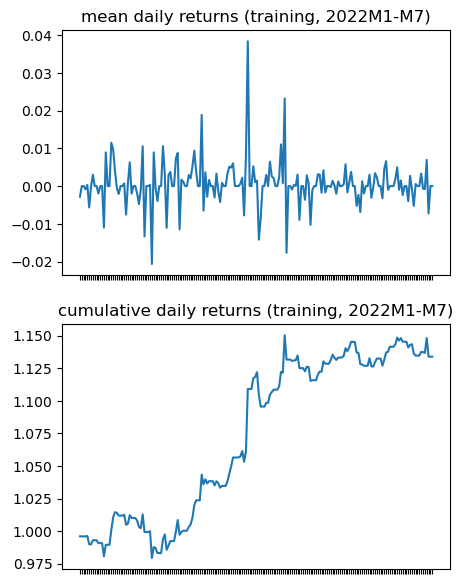

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
2022-01-21 00:00:00,0.987774,0.987310,0.985075,1.002310,NaN,1.000813,NaN,1.008662,NaN,1.000000,0.995992
2022-01-22 00:00:00,0.987774,0.987310,0.985075,1.002310,NaN,1.000813,NaN,1.008662,NaN,1.000000,0.995992
2022-01-23 00:00:00,0.987774,0.987310,0.985075,1.002310,NaN,1.000813,NaN,1.008662,NaN,1.000000,0.995992
2022-01-24 00:00:00,0.987774,0.987310,0.985075,0.990429,1.004032,1.000000,0.995495,1.017476,NaN,0.995804,0.995933
2022-01-25 00:00:00,0.975032,0.987310,1.029851,0.981188,0.995968,0.987805,0.995495,1.030431,NaN,0.983217,0.996255
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27 00:00:00,1.212027,1.060097,2.144318,1.232340,0.912376,1.069843,0.821884,1.022348,0.841674,1.050876,1.136778
2022-07-28 00:00:00,1.218537,1.062795,2.224160,1.243784,0.912376,1.079988,0.830242,1.017447,0.841674,1.050876,1.148188
2022-07-29 00:00:00,1.205134,1.049239,2.121506,1.212535,0.915859,1.076299,0.833085,1.017447,0.857407,1.050876,1.133938
2022-07-30 00:00:00,1.205134,1.049239,2.121506,1.212535,0.915859,1.076299,0.833085,1.017447,0.857407,1.050876,1.133938


In [13]:
# Visualize returns for traininig period
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5, 7]

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(return_summary['mean'])
ax1.title.set_text('mean daily returns (training, 2022M1-M7)')


ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(cumreturn_summary['mean'])
ax2.title.set_text('cumulative daily returns (training, 2022M1-M7)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

# display cumulative returns
cumreturn_summary

#### 3.1.2 Daily returns from validation period (2022M8-M9)

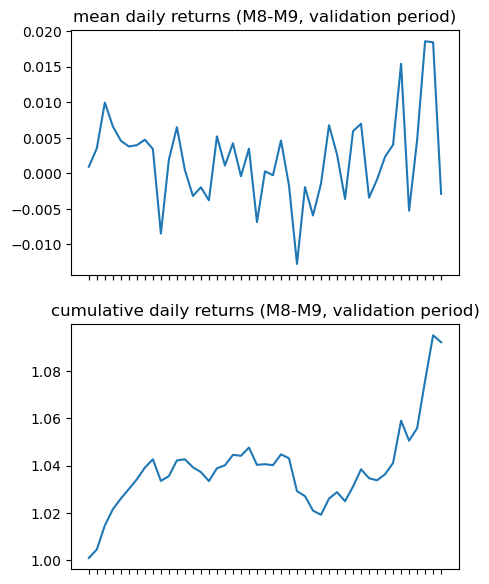

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-08-01 00:00:00,0.991738,1.002519,1.000000,0.987659,0.988506,1.000000,0.979381,1.050357,1.009174,1.000000,1.000933
2022-08-02 00:00:00,0.991113,0.997481,1.000000,0.993325,0.988506,1.006814,0.979381,1.067857,1.027523,0.993598,1.004560
2022-08-03 00:00:00,1.010492,1.010076,1.010870,0.991534,0.996928,1.021295,0.979381,1.086786,1.045872,0.993598,1.014683
2022-08-04 00:00:00,1.012992,1.012594,0.999761,0.989392,0.993034,1.040034,0.979381,1.103571,1.064220,1.020280,1.021526
2022-08-05 00:00:00,1.026432,1.022670,0.999761,0.989392,1.016218,1.042589,0.979381,1.100000,1.055046,1.029174,1.026066
2022-08-08 00:00:00,1.024244,1.020151,0.999761,0.989756,1.012354,1.045997,0.979381,1.104643,1.082569,1.041880,1.030074
2022-08-09 00:00:00,1.031589,1.022670,0.999761,0.989756,1.018150,1.049830,0.985541,1.112500,1.087156,1.045057,1.034201
2022-08-10 00:00:00,1.038934,1.025189,1.007717,0.989756,1.023946,1.053663,0.991701,1.120357,1.091743,1.048233,1.039124
2022-08-11 00:00:00,1.046123,1.030227,1.034236,0.980277,1.012354,1.061329,1.000940,1.122143,1.091743,1.046963,1.042633


In [14]:
# Visualize returns for test period

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(return_eval_summary['mean'])
ax1.title.set_text('mean daily returns (M8-M9, validation period)')

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
ax2.plot(cumreturn_eval_summary['mean'])
ax2.title.set_text('cumulative daily returns (M8-M9, validation period)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

# display cumulative returns
cumreturn_eval_summary

#### 3.1.3 Daily returns from test period (2022M10)

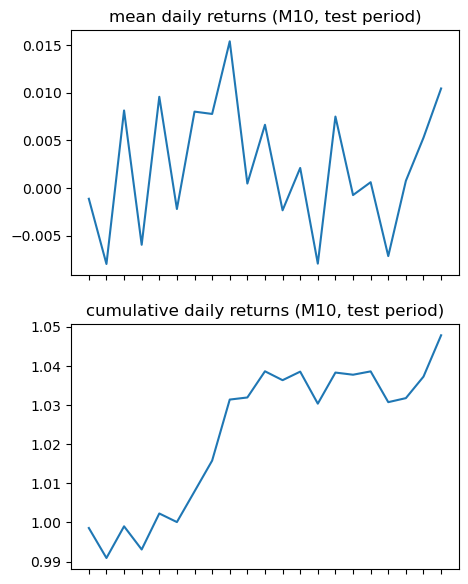

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-10-03 00:00:00,1.007188,1.006645,1.009709,1.003440,0.977444,1.000000,NaN,0.984315,NaN,1.000000,0.998592
2022-10-04 00:00:00,1.000200,1.006645,0.989911,1.000361,0.973684,0.985544,0.996753,0.956208,1.000000,1.000000,0.990931
2022-10-05 00:00:00,0.999001,1.020111,0.989911,0.986972,0.996068,0.990501,1.009656,0.952145,1.045872,1.000000,0.999024
2022-10-06 00:00:00,0.993919,1.006279,0.932800,0.992931,1.007786,0.986370,1.003036,0.956711,1.055046,0.996159,0.993104
2022-10-07 00:00:00,0.990369,1.016376,1.000640,0.994421,1.003787,0.985544,1.003036,0.952914,1.073395,1.002561,1.002304
2022-10-10 00:00:00,0.998654,1.006075,0.975200,0.980640,1.019657,0.985544,1.003036,0.961254,1.082569,0.988476,1.000111
2022-10-11 00:00:00,0.995043,1.026263,1.007438,0.981013,1.015562,0.984706,1.019319,0.994382,1.082569,0.973111,1.007941
2022-10-12 00:00:00,0.990562,1.054284,0.998828,0.978404,1.023687,0.990563,1.036139,1.029875,1.082569,0.973111,1.015802
2022-10-13 00:00:00,1.015134,1.098675,1.024222,0.987302,1.023687,0.999876,1.053524,1.036806,1.082569,0.992242,1.031404


In [15]:
#### Visualize returns for test period

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(return_oct_summary['mean'])
ax1.title.set_text('mean daily returns (M10, test period)')

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
ax2.plot(cumreturn_oct_summary['mean'])
ax2.title.set_text('cumulative daily returns (M10, test period)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

# display cumulative returns
cumreturn_oct_summary

### 3.2 Computing annual volativity and sharpe ratio


In [16]:
def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    
    return s

# annual volatility

def annual_vola(data):
    s = std_dev(data)
    annual_volatility = 252**(1/2) * s
    
    return annual_volatility

# Sharpe Ratio From Scratch
def sharpe_ratio(data, 
                 risk_free_rate=((1.03465)**(1/365)-1)): # 3.5% PA risk-free rate based on singapore's tbills
                    
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

In [18]:
# annual vola for train (2022M1-M7), validation (2022M8-M9), and test period (2022M10)

print("####### annual vola #######")
print("train period (2022M1-M7) = {}".format(annual_vola(return_summary['mean'])))
print("validation period (2022M8-M9) = {}".format(annual_vola(return_eval_summary['mean'])))
print("test period (2022M10) = {}".format(annual_vola(return_oct_summary['mean'])))
print()

print("####### sharpe ratio #######")
print("train period (2022M1-M7) = {}".format(sharpe_ratio(return_summary['mean'])))
print("validation period (2022M8-M9) = {}".format(sharpe_ratio(return_eval_summary['mean'])))
print("test period (2022M10) = {}".format(sharpe_ratio(return_oct_summary['mean'])))

####### annual vola #######
train period (2022M1-M7) = 0.09104763218373926
validation period (2022M8-M9) = 0.09879472358774025
test period (2022M10) = 0.10536729880701697

####### sharpe ratio #######
train period (2022M1-M7) = 1.3297738465872508
validation period (2022M8-M9) = 4.902092329161754
test period (2022M10) = 5.165177121803601
